In [1]:
import numpy as np
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

In [2]:
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')

In [3]:
!wget https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py

--2022-06-15 15:27:33--  https://raw.githubusercontent.com/raeubaen/RadioMonteCarlo/main/tf_keras_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7649 (7.5K) [text/plain]
Saving to: ‘tf_keras_model.py.3’

tf_keras_model.py.3 100%[===================>]   7.47K  --.-KB/s    in 0s      

2022-06-15 15:27:33 (105 MB/s) - ‘tf_keras_model.py.3’ saved [7649/7649]



In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# VANNO TUTTI CAMBIATI

# !wget https://www.dropbox.com/s/6s5khncrval4rz9/bkg_et.npy?dl=1 -o bkg_et.npy
# !wget https://www.dropbox.com/s/qc7z1nhqh5xvpbg/bkg_mask.npy?dl=1 -o bkg_mask.npy
# !wget https://www.dropbox.com/s/fs5e9wuhqtr66xh/bkg_xy.npy?dl=1 -o bkg_xy.npy
# !wget https://www.dropbox.com/s/w0b94xzyk2wg7y4/signal_et.npy?dl=1 -o signal_et.npy
# !wget https://www.dropbox.com/s/3k6b0u3zz65xnyf/signal_mask.npy?dl=1 -o signal_mask.npy
# !wget https://www.dropbox.com/s/chcep3q8terrj4k/signal_xy.npy?dl=1 -o signal_xy.npy

In [6]:
import tensorflow as tf
from tensorflow import keras
from tf_keras_model import get_particle_net, get_particle_net_lite, edge_conv

[2022-06-15 15:27:38,798] INFO: NumExpr defaulting to 2 threads.


In [7]:
data_folder = "/content/drive/MyDrive/datiML"

name_map = {"points": "xy", "features": "et", "mask": "mask"} # va provato sia xy che rphi


signal  = {key: np.load(f"{data_folder}/signal_{ name_map[key]}.npy") for key in name_map}

mnbs    = {key: np.load(f"{data_folder}/mnbs_{   name_map[key]}.npy") for key in name_map}

cosmics = {key: np.load(f"{data_folder}/cosmics_{name_map[key]}.npy") for key in name_map}

In [8]:
S =  signal["mask"].shape[0] #entries segnale
F =    mnbs["mask"].shape[0] #entries mnbs (background flash da fascio)
C = cosmics["mask"].shape[0] #entries cosmici

N = S + F + C

p = np.random.permutation(N) #

In [9]:
'''
cluster su disco 0 sopra 50 MeV in un injection cycle:
RMC: 66
MNBS: 107k
cosmici: 4

cluster simulati su disco 0 sopra i 50 MeV:
RMC: 150k
MNBS: 16505 * 5 = 82k
cosmici: 53k

pesi:
RMC: 66/150k 
MNBS: 107k/82k
Cosmici: 4/53k
'''

signal_weight = 66/S * 100
mnbs_weight = 1.07e3/F * 100
cosmics_weight = 4/C * 100

In [10]:
data = {key: np.concatenate( (signal[key], mnbs[key], cosmics[key]) )[p] for key in name_map}

label_list = [1, 0, 0]
entries_list = [S, F, C]
weight_list = [signal_weight, mnbs_weight, cosmics_weight]

print(f"#Entries per signale, mnbs e cosmici:{entries_list}")
print(f"#Pesi per signale, mnbs e cosmici:{weight_list}")

label = np.concatenate( 
    [ np.ones((e))*l for e, l in zip(entries_list,  label_list) ]
)[p]

sample_weight = np.concatenate( 
    [ np.ones((e))*w for e, w in zip(entries_list, weight_list) ]
)[p]

[63721, 82213, 52984]
[0.10357652893080774, 1.3014973301059445, 0.007549448890231013]


In [11]:
train_data  = {key: data[key][int(N*0.0) : int(N*0.7)] for key in name_map}
test_data   = {key: data[key][int(N*0.7) : int(N*0.9)] for key in name_map}
val_data    = {key: data[key][int(N*0.9) : int(N*1.0)] for key in name_map}

train_label = label[int(N*0.0) : int(N*0.7)]
test_label  = label[int(N*0.7) : int(N*0.9)]
val_label   = label[int(N*0.9) : int(N*1.0)]

train_weight = sample_weight[int(N*0.0) : int(N*0.7)]
test_weight  = sample_weight[int(N*0.7) : int(N*0.9)]
val_weight   = sample_weight[int(N*0.9) : int(N*1.0)]

In [18]:
model_type = 'particle_net_lite' # choose between 'particle_net' and 'particle_net_lite'
num_classes = 2
input_shapes = {'points': (50, 2), 'features': (50, 2), 'mask':(50, 1)}

if 'lite' in model_type:
    model = get_particle_net_lite(num_classes, input_shapes)
else:
    model = get_particle_net(num_classes, input_shapes)

In [13]:
# Training parameters
batch_size = 1024 if 'lite' in model_type else 384
epochs = 30

In [14]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [19]:
model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
model.summary()

[2022-06-15 15:36:37,512] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 50, 1)]      0           []                               
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 50, 1)       0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_2 (TFOpLambda)         (None, 50, 1)        0           ['tf.math.not_equal_1[0][0]']    
                                                                                                  
 tf.math.equal_1 (TFOpLambda)   (None, 50, 1)        0           ['tf.cast_2[0][0]']    

In [20]:
# Prepare model model saving directory.
import os
save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, progress_bar] #, lr_scheduler

In [21]:
history = model.fit(
    [train_data["points"], train_data["features"], train_data["mask"]], 
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([val_data["points"], val_data["features"], val_data["mask"]], val_label, val_weight),
    shuffle=True,
    sample_weight=train_weight,
    callbacks=callbacks
)

Epoch 1/30
      0/Unknown - 29s 0s/sample - loss: 0.1098 - accuracy: 0.7026 - precision_1: 0.7230 - recall_1: 0.1151
Epoch 1: val_accuracy improved from -inf to 0.72572, saving model to model_checkpoints/particle_net_lite_model.001.h5
136/136 [==============================] - 36s 268ms/sample - loss: 0.1098 - accuracy: 0.7026 - precision_1: 0.7230 - recall_1: 0.1151 - val_loss: 0.2867 - val_accuracy: 0.7257 - val_precision_1: 0.5588 - val_recall_1: 0.6334
Epoch 2/30
  0/136 [..............................] - ETA: 0s - loss: 0.0731 - accuracy: 0.7879 - precision_1: 0.8761 - recall_1: 0.3929
Epoch 2: val_accuracy improved from 0.72572 to 0.78961, saving model to model_checkpoints/particle_net_lite_model.002.h5
136/136 [==============================] - 31s 227ms/sample - loss: 0.0731 - accuracy: 0.7879 - precision_1: 0.8761 - recall_1: 0.3929 - val_loss: 0.1535 - val_accuracy: 0.7896 - val_precision_1: 0.7712 - val_recall_1: 0.4766
Epoch 3/30
  0/136 [..............................] - 

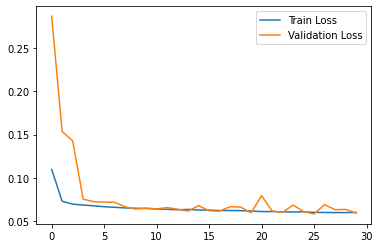

In [22]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.legend()

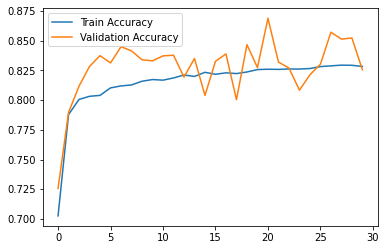

In [23]:
plt.plot(history.history['accuracy'], label="Train Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation Accuracy")
plt.legend()

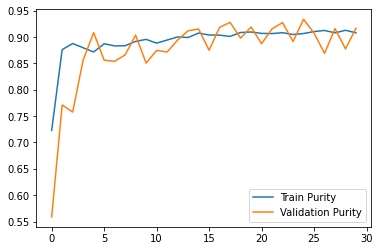

In [25]:
plt.plot(history.history['precision_1'], label="Train Purity")
plt.plot(history.history['val_precision_1'], label="Validation Purity")
plt.legend()

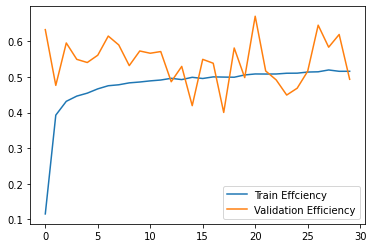

In [26]:
plt.plot(history.history['recall_1'], label="Train Effciency")
plt.plot(history.history['val_recall_1'], label="Validation Efficiency")
plt.legend()

In [ ]:
probs = model.predict_on_batch(test_data)
precision, recall, thresholds = precision_recall_curve(test_label, probs, sample_weight=test_weight)
plt.plot(recall, precision)